In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns

import cvxpy as cp
import mosek

from tqdm import tqdm

from rkhs import setup_full_cvx_dual, runCV, compute_shifted_coverage
from group import compute_split_coverages, compute_group_coverages
from density_estimation import compute_coverage_under_density_shift

### Construct Dataset

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
ny_data = data_source.get_data(states=["NY"], download=True)

In [22]:
#features = ["AGEP","SCHL","SEX","RAC1P","JWTR","POVPIP","JWMNP"]
features = ["AGEP","SEX","RAC1P","POVPIP","JWMNP"]

ca_data_sub = ca_data[features].copy()
ny_data_sub = ny_data[features].copy()
#ca_data_sub.loc[np.isnan(ca_data_sub['SCHL']),'SCHL'] = 0
#ca_data_sub.loc[np.isnan(ca_data_sub['JWTR']),'JWTR'] = 0

#ca_data_sub.loc[ca_data_sub['SCHL'] <= 15,'SCHL'] = 0
#ca_data_sub.loc[np.logical_and(ca_data_sub['SCHL'] <= 19, ca_data_sub['SCHL'] > 15),'SCHL'] = 1
#ca_data_sub.loc[np.logical_or(ca_data_sub['SCHL'] == 20, ca_data_sub['SCHL'] == 21),'SCHL'] = 2
#ca_data_sub.loc[ca_data_sub['SCHL'] > 21,'SCHL'] = 3

#ca_data_sub['SCHL'] = ca_data_sub['SCHL'].astype('category')
ca_data_sub['SEX'] = ca_data_sub['SEX'].astype('category')
ca_data_sub['RAC1P'] = ca_data_sub['RAC1P'].astype('category')

ny_data_sub['SEX'] = ny_data_sub['SEX'].astype('category')
ny_data_sub['RAC1P'] = ny_data_sub['RAC1P'].astype('category')
#ca_data_sub['JWTR'] = ca_data_sub['JWTR'].astype('category')

ca_data_sub['POVPIP'] = (ca_data_sub['POVPIP'] - np.mean(ca_data_sub['POVPIP']))/np.std(ca_data_sub['POVPIP'])
ca_data_sub['AGEP'] = (ca_data_sub['AGEP'] - np.mean(ca_data_sub['AGEP']))/np.std(ca_data_sub['AGEP'])

ny_data_sub['POVPIP'] = (ny_data_sub['POVPIP'] - np.mean(ny_data_sub['POVPIP']))/np.std(ny_data_sub['POVPIP'])
ny_data_sub['AGEP'] = (ny_data_sub['AGEP'] - np.mean(ny_data_sub['AGEP']))/np.std(ny_data_sub['AGEP'])

ca_data_sub = ca_data_sub[~ca_data_sub.isnull().any(axis=1)]
ny_data_sub = ny_data_sub[~ny_data_sub.isnull().any(axis=1)]

Y_ny = ny_data_sub['JWMNP']
X_ny = pd.get_dummies(ny_data_sub)
X_ny = X_ny.drop(columns = ['JWMNP'])

Y_ca = ca_data_sub['JWMNP']
X_ca = pd.get_dummies(ca_data_sub)
X_ca = X_ca.drop(columns = ['JWMNP'])

X_ny.head()

,AGEP,POVPIP,SEX_1,SEX_2,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
17,0.176987,-0.839138,0,1,1,0,0,0,0,0,0,0,0
27,0.389267,-1.709452,0,1,1,0,0,0,0,0,0,0,0
51,-0.502308,-1.280256,0,1,0,0,0,0,0,0,0,1,0
75,0.856282,-1.023931,1,0,0,0,0,0,0,0,0,0,1
157,-0.714588,-1.858479,0,1,0,1,0,0,0,0,0,0,0


In [5]:
def make_train_test_split(X,Y,num_calib=1500,num_test=200):

    x_train, x_calib, y_train, y_calib = train_test_split(X, Y, test_size=num_calib + num_test)

    reg = LinearRegression().fit(x_train, y_train)
    scores = np.array(np.abs(reg.predict(x_calib) - y_calib))

    x_calib = pd.DataFrame.to_numpy(x_calib)

    calibration_set_size = num_calib  
    x_calib_final, x_test, scores_calib, scores_test =  train_test_split(x_calib, scores,
                                                            test_size=len(scores) - calibration_set_size)
    x_calib_cont = x_calib_final[:,:2]
    x_calib_cat = x_calib_final[:,2:]

    x_test_cont = x_test[:,:2]
    x_test_cat = x_test[:,2:]
    
    return x_calib_cont, x_calib_cat, x_test_cont, x_test_cat, scores_calib, scores_test, reg

### Compute Coverage On Test Set

In [34]:
def compute_adaptive_and_split_coverage(x_calib_cont,x_calib_cat,x_test_cont,x_test_cat,scores_calib,scores_test,
                                       gamma=2, alpha=0.9, k=5, min_radius = 1, max_radius = 4000, num_radii = 40,
                                        radius = None
                                       ):
    if radius is None:
        allLosses, radii = runCV(x_calib_cont,scores_calib,"rbf",gamma,alpha,k,min_radius,
                                  max_radius, num_radii, x_calib_cat)
        selectedRadius = radii[np.argmin(allLosses)]
    else:
        selectedRadius = radius
        
    prob = setup_full_cvx_dual(
                x_calib_cont,
                scores_calib,
                kernel="rbf",
                gamma=gamma,
                alpha=alpha,
                z_calib = x_calib_cat
            )
    prob.param_dict['radius'].value = np.asarray([[selectedRadius]])
    prob.solve(
            solver='MOSEK', 
            verbose=False, 
            mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.dual}
          )

    est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
            scores_test,
            scores_calib,
            x_calib_cont,
            x_test_cont,
            None,
            "rbf",
            alpha,
            selectedRadius,
            gamma,
            x_calib_cat,
            x_test_cat
        )

    adaptive_coverages = scores_test <= thresholds
    
    split_threshold = np.quantile(scores_calib, [alpha * (1 + 1/len(scores_calib))])
    split_coverages = scores_test <= split_threshold
    
    return adaptive_coverages, split_coverages, selectedRadius

### Plot Coverage Over Groups For One Run

100%|█████████████████████████████████████████| 200/200 [07:48<00:00,  2.34s/it]


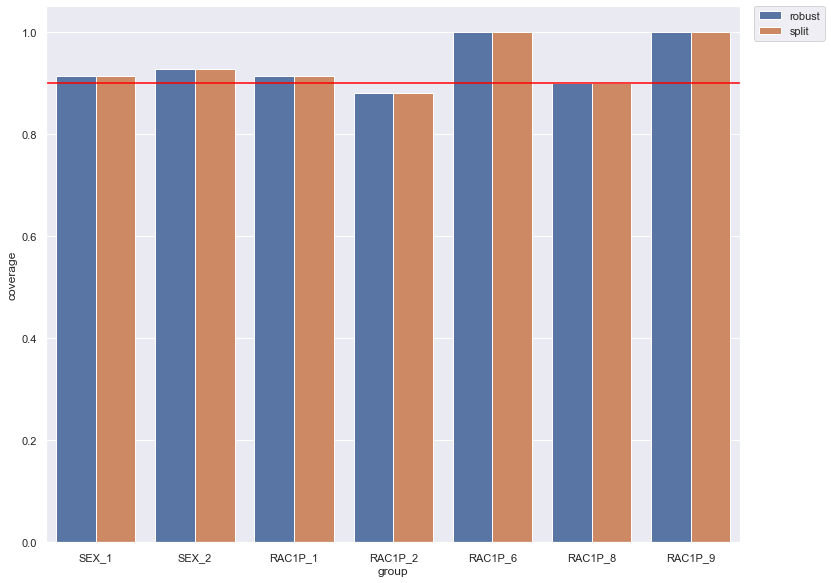

In [27]:
gamma = 0.5
alpha = 0.9
k = 5
min_radius = 1
max_radius = 3000
num_radii = 40
num_calib=1500
num_test=200

x_calib_cont, x_calib_cat, x_test_cont, x_test_cat, scores_calib, scores_test, _ = make_train_test_split(X_ny,Y_ny,
                                                                                                      num_calib,
                                                                                                      num_test)
adaptive_coverages, split_coverages, _ = compute_adaptive_and_split_coverage(x_calib_cont,x_calib_cat,
                                                                          x_test_cont,x_test_cat,
                                                                          scores_calib,scores_test,
                                                                          gamma, alpha, k,
                                                                          min_radius, max_radius,
                                                                          num_radii
                                                                          )

group_data = pd.DataFrame()

for i in range(x_test_cat.shape[1]):
    if sum(x_test_cat[:,i]) > 0:
        group_cov_adaptive = (x_test_cat[:,i] @ adaptive_coverages)/sum(x_test_cat[:,i])
        group_split_adaptive = (x_test_cat[:,i] @ adaptive_coverages)/sum(x_test_cat[:,i])
    
        df = pd.DataFrame({'group' : [X.columns[i+2],X.columns[i+2]],
                            'coverage': [group_cov_adaptive,group_split_adaptive], 
                            'type' : ['robust','split'],
                            'sample_size' : [sum(x_test_cat[:,i]),sum(x_test_cat[:,i])]
                          })

        group_data = pd.concat([group_data, df], axis=0)
    
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig = sns.barplot(group_data, 
            x="group", y="coverage", hue="type")
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Look at coverage over just groups

In [28]:
group_data = pd.DataFrame()
for i in range(25):
    x_train, x_calib, y_train, y_calib = train_test_split(X_ny, Y_ny, test_size=3000)

    reg = LinearRegression().fit(x_train, y_train)
    scores = np.array(np.abs(reg.predict(x_calib) - y_calib))

    x_calib = pd.DataFrame.to_numpy(x_calib)

    calibration_set_size = 1500  
    x_calib_final, x_test, scores_calib, scores_test =  train_test_split(x_calib, scores,
                                                            test_size=len(scores) - calibration_set_size)
    x_calib_cont = x_calib_final[:,:2]
    x_calib_cat = x_calib_final[:,2:]

    x_test_cont = x_test[:,:2]
    x_test_cat = x_test[:,2:]
    adaptive_coverages = compute_group_coverages(
        x_calib_cat, scores_calib, scores_test, x_test_cat, x_test_cat, alpha
    )
    split_coverages = compute_split_coverages(scores_calib,scores_test,x_test_cat,alpha)
    df = pd.DataFrame({'group' : list(adaptive_coverages.keys()) +  list(split_coverages.keys()),
                        'coverage': list(adaptive_coverages.values()) + list(split_coverages.values()), 
                        'type' : ['robust']*len(adaptive_coverages) + ['split']*len(split_coverages)
                        })
    group_data = pd.concat([group_data, df], axis=0)


 12%|████▊                                   | 181/1500 [00:04<00:32, 40.61it/s]


KeyboardInterrupt: 

In [ ]:
group_data_drop = group_data[np.logical_not(np.isnan(group_data['coverage']))].copy()

sns.set(rc={'figure.figsize':(11.7,8.27)})

fig = sns.barplot(group_data_drop, 
            x="group", y="coverage", hue="type", errorbar=('ci', 95))
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Run Full Experiment Multiple Times

In [87]:
def run_one_synthetic_experiment(X_base, Y_base, X_target, Y_target,
                                 num_calib, num_test, gamma, alpha, k, min_radius, max_radius, num_radii,
                                min_radius_density_shift, max_radius_density_shift):
    
    x_calib_cont, x_calib_cat, x_test_cont, x_test_cat, scores_calib, scores_test, reg = make_train_test_split(
                                                                                                    X_base,Y_base,
                                                                                                    num_calib,
                                                                                                    num_test)
    scores_target = np.array(np.abs(reg.predict(X_target) - Y_target))
    x_target_cont = X_target[:,:2]
    x_target_cat = X_target[:,2:]


    adaptive_coverages_test, split_coverages_test, radius = compute_adaptive_and_split_coverage(x_calib_cont,
                                                                          x_calib_cat,
                                                                          x_test_cont,x_test_cat,
                                                                          scores_calib,scores_test,
                                                                          gamma, alpha, k,
                                                                          min_radius, max_radius,
                                                                          num_radii
                                                                          )
    ### Get group coverage
    group_data = pd.DataFrame()

    for i in range(x_test_cat.shape[1]):
        if sum(x_test_cat[:,i]) > 0:
            group_cov_adaptive = (x_test_cat[:,i] @ adaptive_coverages_test)/sum(x_test_cat[:,i])
            group_split_adaptive = (x_test_cat[:,i] @ split_coverages_test)/sum(x_test_cat[:,i])
    
            df = pd.DataFrame({'group' : [X_base.columns[i+2],X_base.columns[i+2]],
                            'coverage': [group_cov_adaptive,group_split_adaptive], 
                            'type' : ['robust','split'],
                            'sample_size' : [sum(x_test_cat[:,i]),sum(x_test_cat[:,i])]
                          })

            group_data = pd.concat([group_data, df], axis=0)
            
            
    ### Compare shift in POVPIP + Age for two states
    est_cov = compute_coverage_under_density_shift(x_calib_cont,scores_calib,x_target_cont,
                                                   "rbf",gamma,alpha,radius,
                                                   k, min_radius_density_shift, max_radius_density_shift, num_radii)
    adaptive_coverages_target, split_coverages_target, _ = compute_adaptive_and_split_coverage(x_calib_cont,
                                                                          x_calib_cat,
                                                                          x_target_cont[0:num_test,:],
                                                                          x_target_cat[0:num_test,:],
                                                                          scores_calib,scores_target[0:num_test],
                                                                          gamma, alpha, radius = radius
                                                                          )
    state_shift_df = pd.DataFrame({'coverage': [sum(adaptive_coverages_target)/len(adaptive_coverages_target),
                                                sum(split_coverages_target)/len(adaptive_coverages_target),est_cov], 
                            'type' : ['robust','split','estimated'],
                          })
    
    return group_data, state_shift_df

gamma = 0.5
alpha = 0.9
k = 5
min_radius = 1
max_radius = 2000
num_radii = 20
num_calib = 1000
num_test = 200
num_target = 1000
min_radius_density_shift = 0.01
max_radius_density_shift = 100
                                 
n_trials = 15

X_ca_mod = pd.DataFrame.to_numpy(X_ca)
group_data = pd.DataFrame()
state_shift_data = pd.DataFrame()
for i in range(n_trials):
    print("Trial number",i)
    df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
                                                            num_calib, num_test, gamma, alpha, k, min_radius,
                                                            max_radius, num_radii, min_radius_density_shift, 
                                                            max_radius_density_shift)
    group_data = pd.concat([group_data, df_group], axis=0)
    state_shift_data = pd.concat([state_shift_data,df_state_shift], axis=0)


/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 0


100%|████████████████████████████████████████| 20/20 [01:52<00:00,  5.62s/it]


[-0.50044043 -0.52218653 -0.54145323 -0.55861117 -0.5739582  -0.58773055
 -0.60012598 -0.61130626 -0.62140635 -0.63055265 -0.63880019 -0.64627053
 -0.65301928 -0.65910631 -0.66458322 -0.6694943  -0.67387905 -0.67777137
 -0.6812014  -0.68419652]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:10<00:00,  1.25s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 1


100%|████████████████████████████████████████| 20/20 [01:56<00:00,  5.85s/it]


[-0.50047989 -0.52413794 -0.54503063 -0.56357746 -0.58010421 -0.5948818
 -0.60812583 -0.62001998 -0.63071287 -0.64033061 -0.64897921 -0.65674851
 -0.66371616 -0.66994827 -0.67550262 -0.68042811 -0.68476927 -0.68856436
 -0.69184594 -0.69465454]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:12<00:00,  1.26s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 2


100%|████████████████████████████████████████| 20/20 [01:57<00:00,  5.88s/it]


[-0.50039398 -0.51975062 -0.53672612 -0.55176953 -0.56512264 -0.57704922
 -0.58774913 -0.59740193 -0.60608481 -0.61396618 -0.6211205  -0.62762767
 -0.63355286 -0.63897155 -0.64388528 -0.64838499 -0.65249195 -0.65623826
 -0.65965472 -0.66276412]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [03:58<00:00,  1.19s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 3


100%|████████████████████████████████████████| 20/20 [02:00<00:00,  6.03s/it]


[-0.50039552 -0.51982738 -0.53688456 -0.55195067 -0.56533142 -0.57727263
 -0.58797515 -0.59760289 -0.60629388 -0.61416035 -0.62129873 -0.62779059
 -0.6337049  -0.63910095 -0.64403273 -0.6485361  -0.65265823 -0.65643071
 -0.66014695 -0.66303729]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:08<00:00,  1.24s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 4


100%|████████████████████████████████████████| 20/20 [01:53<00:00,  5.69s/it]


[-0.50031756 -0.51576166 -0.52904569 -0.54047386 -0.55038027 -0.55896712
 -0.56641264 -0.57287001 -0.57845753 -0.58327493 -0.58740804 -0.59092672
 -0.59389372 -0.59635778 -0.59836475 -0.59995264 -0.6011487  -0.60200008
 -0.60251453 -0.602721  ]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:03<00:00,  1.22s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 5


100%|████████████████████████████████████████| 20/20 [01:57<00:00,  5.90s/it]


[-0.50038213 -0.51915367 -0.53563274 -0.55019712 -0.56314629 -0.57472064
 -0.58511607 -0.59449156 -0.60298193 -0.61069508 -0.61772419 -0.62414833
 -0.63003782 -0.63543708 -0.64040865 -0.64498957 -0.64921804 -0.65312614
 -0.65674225 -0.66009138]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:22<00:00,  1.31s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 6


100%|████████████████████████████████████████| 20/20 [01:56<00:00,  5.81s/it]


[-0.50043695 -0.52210938 -0.54151062 -0.55900114 -0.57486706 -0.58938226
 -0.60261123 -0.61483589 -0.62614419 -0.63663493 -0.64641781 -0.65557955
 -0.66411994 -0.67216553 -0.67974215 -0.68689204 -0.69365236 -0.70005585
 -0.70613021 -0.71190083]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [05:06<00:00,  1.53s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 7


100%|████████████████████████████████████████| 20/20 [01:58<00:00,  5.92s/it]


[-0.50038835 -0.51957485 -0.53662369 -0.55188605 -0.56563893 -0.57810272
 -0.58945648 -0.59984196 -0.60939041 -0.61820222 -0.62632487 -0.63386875
 -0.64087463 -0.6474116  -0.65349928 -0.65918881 -0.66450901 -0.66949328
 -0.67415458 -0.67852607]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:56<00:00,  1.48s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 8


100%|████████████████████████████████████████| 20/20 [01:53<00:00,  5.65s/it]


[-0.50037095 -0.51847961 -0.53416358 -0.54781927 -0.55976176 -0.57024275
 -0.5794663  -0.58759379 -0.59478214 -0.60112652 -0.60673162 -0.61167688
 -0.61603145 -0.61985532 -0.62319824 -0.62610291 -0.62861234 -0.63075565
 -0.63256052 -0.63403513]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [03:53<00:00,  1.17s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 9


100%|████████████████████████████████████████| 20/20 [01:57<00:00,  5.87s/it]


[-0.50036508 -0.51830771 -0.5340749  -0.54802264 -0.56043593 -0.5715387
 -0.58151286 -0.59051213 -0.59865812 -0.60605587 -0.61278808 -0.61893165
 -0.62454771 -0.62968955 -0.63440287 -0.63872755 -0.64269826 -0.64634471
 -0.64969405 -0.65276884]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [03:11<00:00,  1.05it/s]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 10


100%|████████████████████████████████████████| 20/20 [02:01<00:00,  6.07s/it]


[-0.50035802 -0.5179049  -0.53324468 -0.54675195 -0.55872223 -0.56939213
 -0.57895036 -0.58755208 -0.59532375 -0.60237012 -0.60877881 -0.6146234
 -0.61996682 -0.62486055 -0.62935066 -0.63347608 -0.63727027 -0.64076252
 -0.64397844 -0.6469399 ]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [03:18<00:00,  1.01it/s]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 11


100%|████████████████████████████████████████| 20/20 [01:57<00:00,  5.86s/it]


[-0.50040391 -0.52025698 -0.53771235 -0.55315812 -0.56690604 -0.57920531
 -0.59025934 -0.60022863 -0.60925356 -0.61744715 -0.62490407 -0.6317048
 -0.63791387 -0.64360371 -0.64881104 -0.65358412 -0.65796273 -0.66198004
 -0.66566189 -0.66904286]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:00<00:00,  1.20s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 12


100%|████████████████████████████████████████| 20/20 [02:03<00:00,  6.18s/it]


[-0.5002923  -0.5145207  -0.52677096 -0.53737212 -0.54658355 -0.55461318
 -0.56162895 -0.56776815 -0.57314387 -0.57785014 -0.58196564 -0.58555697
 -0.58868054 -0.59138472 -0.5937108  -0.59567607 -0.59736789 -0.59875706
 -0.59988633 -0.60077776]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [05:19<00:00,  1.60s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 13


100%|████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]


[-0.50042051 -0.52125447 -0.53986428 -0.556603   -0.57175215 -0.58553844
 -0.59814708 -0.60972991 -0.62041668 -0.63029999 -0.63948219 -0.64803378
 -0.65604321 -0.66349315 -0.67050362 -0.67709176 -0.68329375 -0.68913998
 -0.69466015 -0.69987587]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:02<00:00,  1.21s/it]
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/1856564329.py:75: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_group, df_state_shift = run_one_synthetic_experiment(X_ny, Y_ny, X_ca_mod[0:num_target,:], Y_ca[0:num_target],
/usr/local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Trial number 14


100%|████████████████████████████████████████| 20/20 [01:56<00:00,  5.81s/it]


[-0.50043515 -0.52188059 -0.54083415 -0.55770809 -0.57287476 -0.58642618
 -0.59875131 -0.60996313 -0.62020593 -0.6295997  -0.63824507 -0.6462274
 -0.65363792 -0.66048267 -0.66687337 -0.6728308  -0.67840235 -0.68362048
 -0.68851614 -0.69311644]
Selected Radius For Density Fit: 10.0


100%|██████████████████████████████████████| 200/200 [04:45<00:00,  1.43s/it]


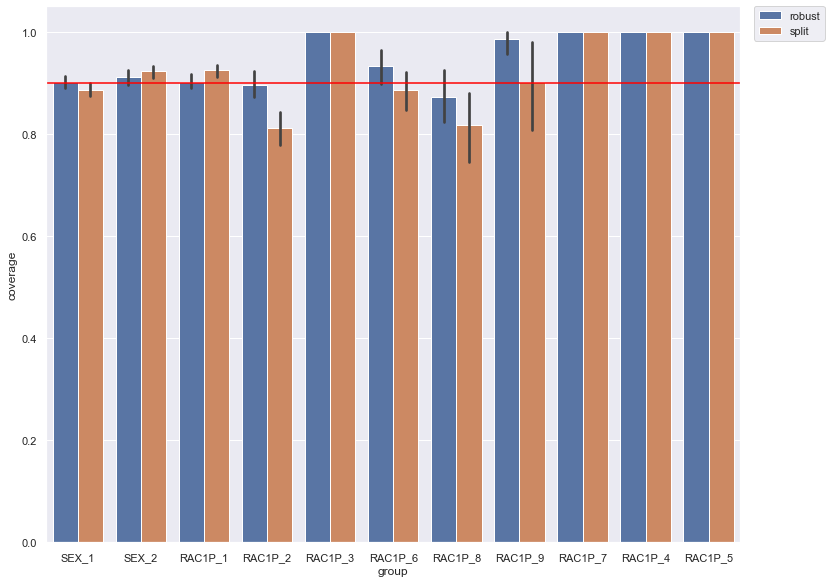

In [88]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig_group = sns.barplot(group_data, 
            x="group", y="coverage", hue="type")
fig_group.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/663409929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust'] = state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust']/200
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_37806/663409929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust'] = state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust']/200
/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_3

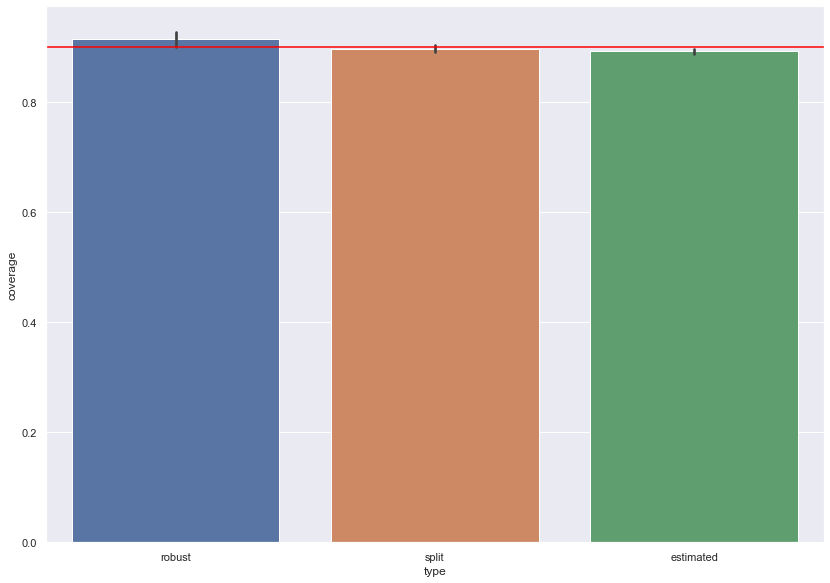

In [91]:
state_shift_data_mod = state_shift_data.copy()
state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust'] = state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'robust']/200
state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'split'] = state_shift_data_mod['coverage'][state_shift_data_mod['type'] == 'split']/200


fig_group = sns.barplot(state_shift_data_mod, 
            x="type", y="coverage")
fig_group.axhline(alpha, color='red')
plt.tight_layout()